/Users/dmurali/miniconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:158: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/Users/dmurali/miniconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dmurali/miniconda3/lib/python3.4/site-packages/pandas/core/frame.py:2650: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


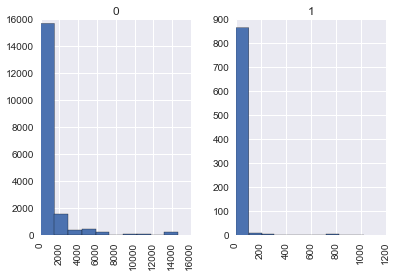

In [2]:
from MongoClient import read_mongo
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import RandomizedSearchCV
import numpy as np
import time
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def reportModelMetric(model, metric, trainingData, algo):
    if metric == 'featureImportance':
        modelMetric =  pd.DataFrame(model.feature_importances_, columns = ['ModelMetric'])
    
    #format the important features predicted by the model
    features = pd.DataFrame(trainingData.columns.values, columns = ['Features'])
    importanceByFeature = pd.concat([features, modelMetric], axis = 1)
    importanceByFeature.sort(['ModelMetric'], inplace = True, ascending = False)
    #write to file
    importanceByFeature.to_csv('../spamSiteFeatureImportance_'+algo+'.csv', index = False)

def predictAndReport(algo, bestParams, train, test):
    if algo == 'rf':
        predictor = RandomForestClassifier(min_samples_split = 7, n_estimators = 70, min_samples_leaf = 14)
    elif algo == 'knn':
        predictor = KNeighborsClassifier(n_neighbors = 12, weights = 'distance')
    elif algo == 'logr':
        predictor = LogisticRegression()
    
    predictor.fit(train, train['isSpam'])
    if algo == 'logr':
        coefficients = pd.DataFrame(predictor.coef_[0], columns = ['Coefficients'])
        features = pd.DataFrame(train.columns.values, columns = ['Features'])
        featureCoefficients = pd.concat([features, coefficients], axis = 1)
        featureCoefficients.sort(['Coefficients'], inplace = True, ascending = False)
        featureCoefficients.to_csv('../spamSiteFeatureCoefficients_'+algo+'.csv', index = False)
        print(featureCoefficients)
    predicted = predictor.predict(test)
    
    dfWithClass = pd.DataFrame(predicted, columns = ['predictedClass'])
    final = pd.concat([test, dfWithClass], axis=1)
    #take a look at the confusion matrix
    print(pd.crosstab(final.predictedClass, final.isSpam, margins = True))
    print("Accuracy: %.3f" %float(np.sum(final.isSpam == final.predictedClass) / float(len(test))))
    print("Precision: %.3f" %float(sum((final.isSpam == 1) & (final.predictedClass == 1)) / sum(final.isSpam == 1)))
    if algo == 'rf':
        reportModelMetric(predictor, 'featureImportance', train, algo)

def searchBestModelParameters(algorithm, trainingData):
    #using randomforest
    if algorithm == 'rf':
        numTrees = range(10, 100, 10)
        numMinLeafSamples = range(2, 20, 2)
        numMinSamplesSplit = range(1, 20, 3)
        paramDistribution = dict(n_estimators = numTrees, min_samples_leaf = numMinLeafSamples, min_samples_split = numMinSamplesSplit)
        model = RandomForestClassifier()
    elif algorithm == 'knn':
        # model the data using knn
        # define the parameter values that should be searched
        k_range = range(1, 50)
        weight_options = ['uniform', 'distance']
        # specify "parameter distributions" rather than a "parameter grid"
        paramDistribution = dict(n_neighbors = k_range, weights = weight_options)
        model = KNeighborsClassifier()
    elif algorithm == 'logr':
        #model data using logistic regression
        model = LogisticRegression()
        %time print(np.sqrt(-cross_val_score(model, trainingData, trainingData['isSpam'], cv=10, scoring='mean_squared_error')).mean())
        return
            
    bestRun = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, paramDistribution, cv=10, scoring = 'accuracy', n_iter = 10)
        rand.fit(trainingData, trainingData['isSpam'])
        # examine the best model
        bestRun.append({'score' : round(rand.best_score_,3), 'params' : rand.best_params_})
    print(max(bestRun, key=lambda x:x['score']))
    return bestRun
    
#set some intial vars
algorithm = 'logr'

#read site
rawSite = read_mongo(db = 'CB', collection = 'site', host = 'localhost', no_id = False)
siteModified = rawSite.drop(['dismissedOnboarding', 'feedCounter', 'feedToken',
              'modules', 'password', 'theme', 'photoId', 'requestAccess',
              'requestPassword', 'cm', 'bi', 'photo', 'goFundMe', 'lastName',
              'numAmps', 'partner', 'size', 'theme', 'createFormSessionId', 'allowList',
              'blockList', 'displayEmail', 'isPhotoOrderingFixed', 'healthCondition',
              'spam', 'status', 'firstName', 'lastInvite'], axis = 1)
siteModified['descriptionLen'] = rawSite.description.str.len()
siteModified.drop(['description'], axis = 1, inplace = True)
siteModified['nameLen'] = rawSite.name.str.len()
siteModified.drop(['name'], axis = 1, inplace = True)
siteModified['titleLen'] = rawSite.title.str.len()
siteModified.drop(['title'], axis = 1, inplace = True)

siteCreatedDayOrNight = ['Night' if(hr > 22 or hr <= 6) else 'Day' for hr in pd.DatetimeIndex(siteModified['createdAt']).hour]
siteModified['siteCreatedDayOrNight'] = siteCreatedDayOrNight
siteModified.drop(['createdAt'], axis = 1, inplace = True)
siteUpdatedDayOrNight = ['Night' if(hr > 22 or hr <= 6) else 'Day' for hr in pd.DatetimeIndex(siteModified['updatedAt']).hour]
siteModified['siteUpdatedDayOrNight'] = siteUpdatedDayOrNight
siteModified.drop(['updatedAt'], axis = 1, inplace = True)

siteModified.descriptionLen.replace(np.nan, -1, inplace = True)
siteModified.age.replace(np.nan, 'blank', inplace = True)
siteModified.hasCommentFix.replace(np.nan, 0, inplace = True)
siteModified.hasVisitorInvite.replace(np.nan, 0, inplace = True)
siteModified.isDeleted.replace(np.nan, 0, inplace = True)
siteModified.isForSelf.replace(np.nan, 0, inplace = True)
siteModified.isSearchable.replace(np.nan, 0, inplace = True)
siteModified.isSpam.replace(np.nan, 0, inplace = True)
siteModified.sawReCaptcha.replace(np.nan, 0, inplace = True)

siteModified.rename(columns={'_id': 'siteId', 'isDeleted' : 'isSiteDeleted', 'sawReCaptcha' : 'sawReCaptchaSite', 'isSpam' : 'isSiteSpam'}, inplace=True)

binarizedSites = pd.get_dummies(siteModified, columns = ['platform', 'privacy', 'age', 'siteCreatedDayOrNight', 'siteUpdatedDayOrNight'])

#print(siteModified.groupby(['siteUpdatedDayOrNight']).size())
#read profile
rawProfile = read_mongo(db = 'CB', collection = 'profile', host = 'localhost', no_id = False)
profileModified = rawProfile.drop(['ampProfile', 'bio', 'cm', 'country', 'createFormSessionId', 'employer',
                'feedCounter', 'guid', 'howFoundOther', 'language', 'lastDrawingTool',
                'lastLastLogin', 'lastLogin', 'lastModifier', 'lastName', 'firstName',
                'lastVideoUpload', 'location', 'mailingAddress', 'mobile', 'my', 'n',
                'notes', 'password', 'phone', 'photo', 'platform', 'sms', 'social',
                'tz', 'whitelistedByCustomerCare', 'handle', 'createdAt', 'updatedAt',
                'lastActivity', 'lastJournalReply', 'ip', 'howFound', 'isStub', 'failedLoginAttempts',
                'isMailSubscriber', 'spam', 'email', 'isSecure', 'isPrivate', 'isPublic',
                'gender'], axis = 1)
#emails = profileModified.email.apply(pd.Series)
#emailDomains = pd.DataFrame(emails.domain.values, columns = ['emailDomain'])
#withoutEmail = profileModified.drop(['email'], axis = 1)
#withDomains = pd.concat([withoutEmail, emailDomains], axis = 1).fillna('blank')
profileModified.sawReCaptcha.replace(np.nan, 0, inplace = True)
profileModified.isDeleted.replace(np.nan, 0, inplace = True)
profileModified.numNotifications.replace(np.nan, -1, inplace = True)

profileModified.rename(columns={'_id': 'profileId', 'isDeleted' : 'isProfileDeleted', 'sawReCaptcha' : 'sawReCaptchaProfile'}, inplace=True)

#read site_profile
rawSiteProfile = read_mongo(db = 'CB', collection = 'site_profile', host = 'localhost')
siteProfile = pd.DataFrame(rawSiteProfile['siteId'], columns = ['siteId'])
siteProfile['profileId'] = rawSiteProfile.userId

#read site_profile with spam
octSiteProfileSpam = pd.read_csv("/Users/dmurali/Documents/spamlist_round25_from_20150809_to_20151015.csv",
                    usecols = ['siteId','isSpam'])
octSiteProfileSpam.rename(columns = {'isSpam':'isOctSpam'}, inplace = True)

mergedSiteProfile = binarizedSites.merge(siteProfile, how='left', on = ['siteId'], sort = False).merge(profileModified, how='left', on = ['profileId'], sort = False).merge(octSiteProfileSpam, how='left', on = ['siteId'], sort = False)
mergedSiteProfile['isSpam'] = np.where(mergedSiteProfile['isOctSpam'].isin(mergedSiteProfile['isSiteSpam']), 1, mergedSiteProfile['isSiteSpam'])

mergedSiteProfile = mergedSiteProfile.convert_objects(convert_numeric=True)
mergedSiteProfile.drop(['isSiteSpam', 'isOctSpam'], axis = 1, inplace = True)

isSpamTest = mergedSiteProfile.loc[mergedSiteProfile['isSpam'] == 1][:340]
isNotSpamTest = mergedSiteProfile.loc[mergedSiteProfile['isSpam'] == 0][:6300]
test = pd.concat([isSpamTest, isNotSpamTest])
train = mergedSiteProfile[~mergedSiteProfile.siteId.isin(test.siteId)]

train.drop(['siteId', 'profileId'], axis = 1, inplace = True)
test.drop(['siteId', 'profileId'], axis = 1, inplace = True)
train.fillna(-1, inplace = True)
test.fillna(-1, inplace = True)

train['visits'].hist(by = train['isSpam'])

#plt.hist(train['visits'].values)
#plt.title("Distribution")
#plt.xlabel("Value")
#plt.ylabel("Frequency")
#plt.show()

bestParams = []

#bestParams = searchBestModelParameters(algorithm, train)

#predictAndReport(algorithm, bestParams, train, test)

